In [148]:
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import re

import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline

import numpy as np

from scipy.interpolate import interp1d

from astropy.time import Time
from astropy.io import fits

In [149]:
from astropy.stats import sigma_clipped_stats
from photutils import CircularAperture
#from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import (ImageNormalize,MinMaxInterval, SqrtStretch)

from photutils import DAOStarFinder
from photutils import make_source_mask
from astropy.stats import SigmaClip
from photutils import Background2D, MedianBackground

In [150]:
plt.rcParams["axes.labelsize"]="large"
plt.rcParams["axes.linewidth"]=2.0
plt.rcParams["xtick.major.size"]=8
plt.rcParams["ytick.major.size"]=8
plt.rcParams["ytick.minor.size"]=5
plt.rcParams["xtick.labelsize"]="large"
plt.rcParams["ytick.labelsize"]="large"

plt.rcParams["figure.figsize"]=(8,8)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'bold'
#plt.rcParams['axes.facecolor'] = 'blue'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['lines.markeredgewidth'] = 0.3 # the line width around the marker symbol
plt.rcParams['lines.markersize'] = 5  # markersize, in points
plt.rcParams['grid.alpha'] = 0.75 # transparency, between 0.0 and 1.0
plt.rcParams['grid.linestyle'] = '-' # simple line
plt.rcParams['grid.linewidth'] = 0.4 # in points
plt.rcParams['font.size'] = 13

In [151]:
def FindSources(data):
    """
    """
    mean, median, std = sigma_clipped_stats(data, sigma=3.0)
    daofind = DAOStarFinder(fwhm=10.0, threshold=10.*std)    
    sources = daofind(data - median) 
    #sources = daofind(data) 
    return sources

In [152]:
def GetExtractionParam(sources,width=20):
    """
    """
    
    y0=sources["ycentroid"][0]
    x0=sources["xcentroid"][0]

    xmin=int(x0-width)
    xmax=int(x0+width)
    ymin=int(y0-width)
    ymax=int(y0+width)
    
    return x0,y0,xmin,xmax,ymin,ymax

In [153]:
# where are the spectra
#----------------------
thedate = "20190215"
rawinput_directory="/Users/dagoret/DATA/PicDuMidiFev2019/prod_"+thedate+"_v4"

In [154]:
#file="T1M_20190216_041126_502_HD116405_Filtre_None_bin1x1.365_red.fit"
file="T1M_20190216_042315_191_HD116405_Filtre_None_bin1x1.372_red.fit"

In [155]:
fullfilename=os.path.join(rawinput_directory,file)

In [156]:
hdu = fits.open(fullfilename)

In [157]:
data=hdu[0].data

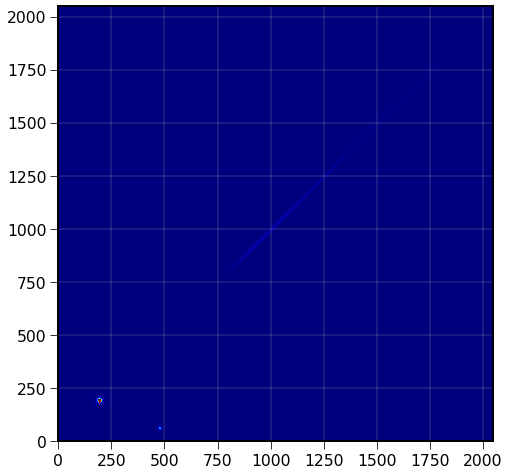

In [158]:
plt.imshow(data,origin="lower",cmap="jet")
plt.grid()

In [159]:
cutimg=data[0:750,0:750]

In [160]:
sources=FindSources(cutimg)

In [161]:
positions = (sources['xcentroid'], sources['ycentroid'])

In [162]:
for col in sources.colnames:    
    sources[col].info.format = '%.8g'  # for consistent table output
print(sources)   

 id xcentroid ycentroid sharpness  ... sky    peak      flux       mag    
--- --------- --------- ---------- ... --- --------- --------- -----------
  1 479.48642 59.269187 0.40441148 ...   0 25812.291 556.00161  -6.8626901
  2 198.39715 191.02711 0.42362149 ...   0 65547.723 846.42423  -7.3189702
  3 192.61871 192.19116 0.34282863 ...   0 64855.828 867.06686  -7.3451315
  4 465.24691 217.55138 0.40557512 ...   0 47.204788  1.118693 -0.12177734
  5 595.93434 379.87027 0.57891742 ...   0 68.468633  2.056827  -0.7829944


In [163]:
sources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,479.48642,59.269187,0.40441148,-0.29930178,-0.11659606,169,0,25812.291,556.00161,-6.8626901
2,198.39715,191.02711,0.42362149,-0.20363119,0.34148734,169,0,65547.723,846.42423,-7.3189702
3,192.61871,192.19116,0.34282863,0.73084413,0.46082192,169,0,64855.828,867.06686,-7.3451315
4,465.24691,217.55138,0.40557512,0.035216845,-0.082626722,169,0,47.204788,1.118693,-0.12177734
5,595.93434,379.87027,0.57891742,-0.11627104,-0.17838172,169,0,68.468633,2.056827,-0.7829944


In [164]:
halfwidth=50
x0,y0,xmin,xmax,ymin,ymax=GetExtractionParam(sources,width=halfwidth)

In [165]:
x0,y0,xmin,xmax,ymin,ymax

(479.4864181546125, 59.26918669426224, 429, 529, 9, 109)

In [166]:
vignette=data[ymin:ymax,xmin:xmax]

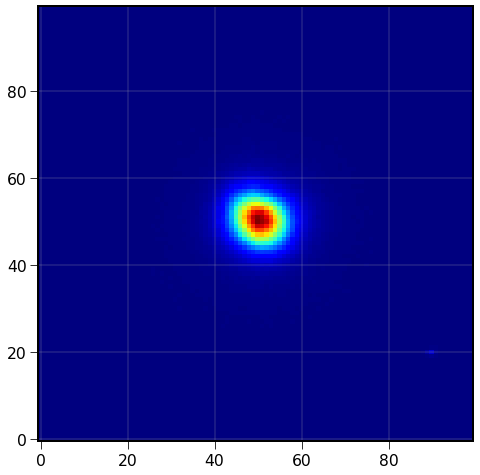

In [167]:
plt.imshow(vignette,origin="lower",cmap="jet")
plt.grid()

In [168]:
from photutils import aperture_photometry
from photutils import CircularAperture

In [169]:
newx0=halfwidth
newy0=halfwidth

In [170]:
aperture= CircularAperture((newx0,newy0), r=25.)

In [171]:
phot_table = aperture_photometry(vignette, aperture)

In [172]:
for col in phot_table.colnames:    
    phot_table[col].info.format = '%.8g'  # for consistent table output

In [173]:
phot_table

id,xcenter,ycenter,aperture_sum
,pix,pix,
int64,float64,float64,float64
1,50,50,3213189.5


In [174]:
all_r=np.arange(1,50)
N=len(all_r)
all_aps=np.zeros(N)
idx=0
for r in all_r:
    aperture= CircularAperture((newx0,newy0), r=r)
    phot_table = aperture_photometry(vignette, aperture)
    aps=phot_table["aperture_sum"][0]
    all_aps[idx]=aps
    idx+=1
maxaps=all_aps.max()

Text(0.5, 1.0, 'Circular Aperture')

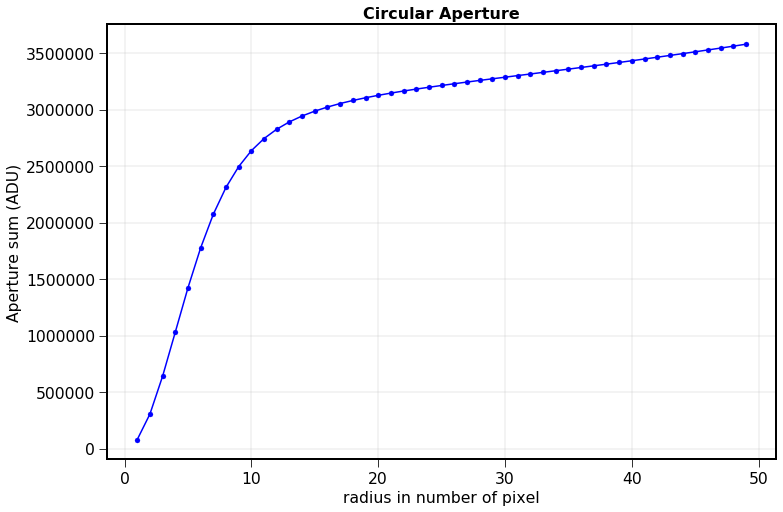

In [175]:
plt.figure(figsize=(12,8))
plt.plot(all_r,all_aps,"b-o")

plt.grid()
plt.xlabel("radius in number of pixel")
plt.ylabel("Aperture sum (ADU)")
plt.title("Circular Aperture")
#plt.legend()

In [176]:
from photutils import CircularAperture, CircularAnnulus

In [177]:
newx0

50

In [178]:
annulus_aperture = CircularAnnulus((newx0,newy0), r_in=40, r_out=50)

In [179]:
annulus_masks = annulus_aperture.to_mask(method='center')

In [180]:
#plt.imshow(annulus_masks[0],cmap="jet")

In [181]:
annulus_data = annulus_masks[0].multiply(vignette)

In [182]:
mask = annulus_masks[0].data
annulus_data_1d = annulus_data[mask > 0]

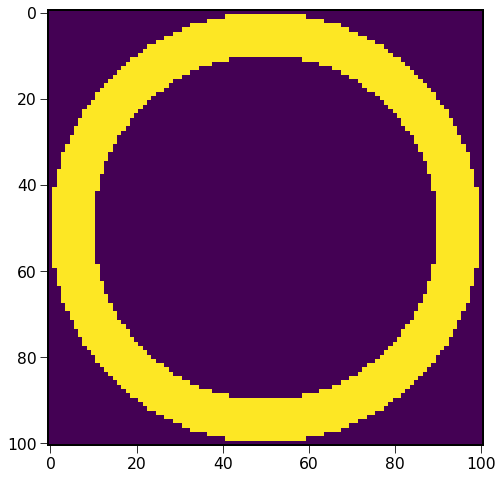

In [183]:
plt.imshow(mask)

In [184]:
 _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)

In [185]:
median_sigclip

58.01776276091676

In [186]:
background = median_sigclip * annulus_aperture.area()

In [187]:
annulus_aperture.area()

2827.4333882308138

In [188]:
np.pi*(50**2-40**2)

2827.4333882308138

In [189]:
 median_sigclip

58.01776276091676

In [190]:
fullbg = np.full_like(annulus_data, median_sigclip)

In [191]:
fullbg

array([[58.01776276, 58.01776276, 58.01776276, ..., 58.01776276,
        58.01776276, 58.01776276],
       [58.01776276, 58.01776276, 58.01776276, ..., 58.01776276,
        58.01776276, 58.01776276],
       [58.01776276, 58.01776276, 58.01776276, ..., 58.01776276,
        58.01776276, 58.01776276],
       ...,
       [58.01776276, 58.01776276, 58.01776276, ..., 58.01776276,
        58.01776276, 58.01776276],
       [58.01776276, 58.01776276, 58.01776276, ..., 58.01776276,
        58.01776276, 58.01776276],
       [58.01776276, 58.01776276, 58.01776276, ..., 58.01776276,
        58.01776276, 58.01776276]])

In [192]:
fullbg.shape

(101, 101)

In [193]:
bg=annulus_masks[0]*fullbg

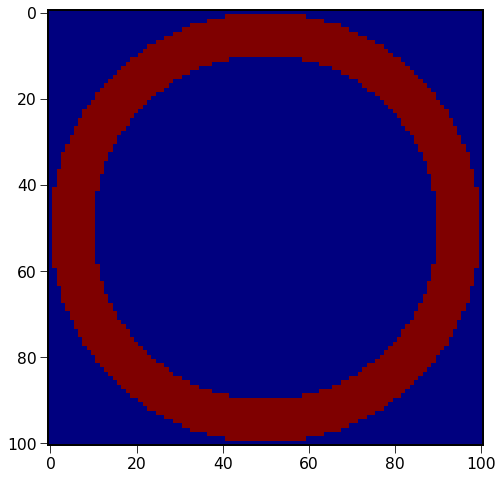

In [194]:
plt.imshow(bg,cmap="jet")

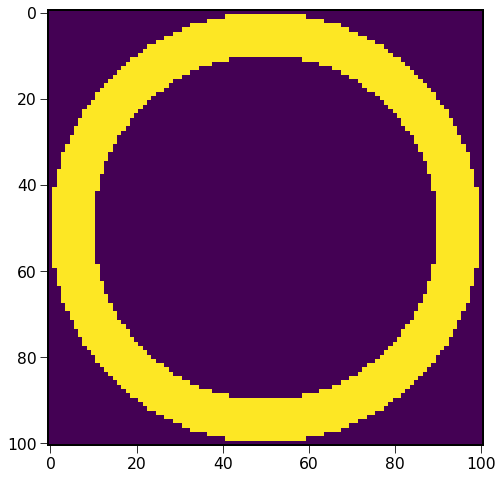

In [195]:
plt.imshow(bg)

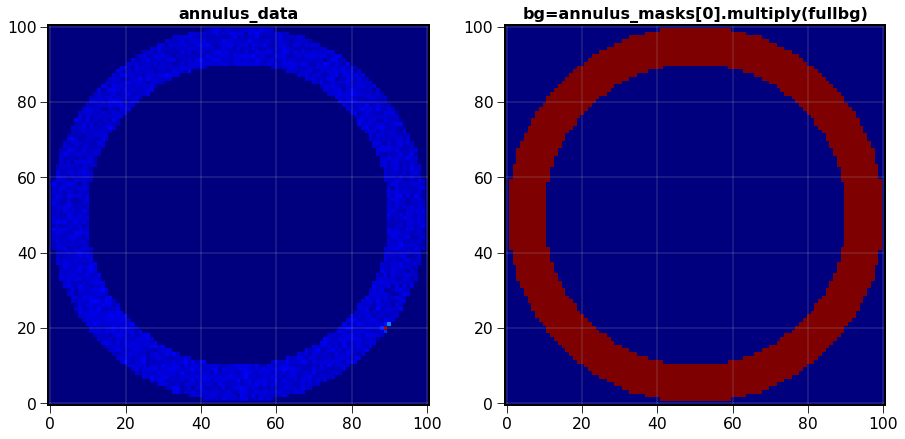

In [196]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(annulus_data,origin="lower",cmap="jet")
plt.title("annulus_data")
plt.grid()
plt.subplot(1,2,2)
plt.imshow(bg,origin="lower",cmap="jet")
plt.title("bg=annulus_masks[0].multiply(fullbg)")
plt.grid()

In [197]:
signal=annulus_data-bg

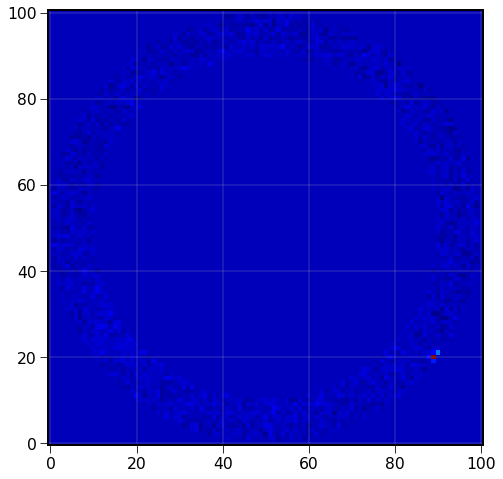

In [198]:
plt.imshow(signal,origin="lower",cmap="jet")
plt.grid()

# Circular photometry

In [199]:
star_aperture= CircularAperture((newx0,newy0), r=25.)

In [200]:
phot_table = aperture_photometry(vignette, star_aperture)

In [201]:
phot_table

id,xcenter,ycenter,aperture_sum
,pix,pix,
int64,float64,float64,float64
1,50.0,50.0,3213189.526871992


## Annulus background extraction

In [207]:
gel=4.8 # electrons per ADU
all_r=np.arange(20,50)
N=len(all_r)
all_aps=np.zeros(N)
idx=0
for r in all_r:
    theannulus_aperture = CircularAnnulus((width,width), r_in=r, r_out=r+5)
    theannulus_masks = theannulus_aperture.to_mask(method='center')
    theannulus_data = theannulus_masks[0].multiply(vignette)  # the annulus data image
    themask = theannulus_masks[0].data
    theannulus_data_1d = theannulus_data[themask > 0]
    _, themedian_sigclip, _ = sigma_clipped_stats(theannulus_data_1d)
    thefullbg = np.full_like(theannulus_data, themedian_sigclip)
    #background = median_sigclip * annulus_aperture.area()
    #thebg=theannulus_masks[0].multiply(thefullbg)
    thebg=theannulus_masks[0]*thefullbg
    #thesignal=theannulus_data-thebg
    theerror = np.sqrt(vignette/gel) # should be better calculated
    phot = aperture_photometry(vignette, star_aperture,error=theerror)
    phot['annulus_median'] = themedian_sigclip
    phot['aper_bkg'] = themedian_sigclip * star_aperture.area()
    phot['aper_sum_bkgsub'] = phot['aperture_sum'] - phot['aper_bkg']
    for col in phot.colnames:
        phot[col].info.format = '%.8g'  # for consistent table output
    print(phot)
    all_aps[idx]=phot["aper_sum_bkgsub"]
    idx+=1
maxaps=all_aps.max()

 id xcenter ycenter aperture_sum ... annulus_median aper_bkg aper_sum_bkgsub
      pix     pix                ...                                        
--- ------- ------- ------------ ... -------------- -------- ---------------
  1      50      50    3213189.5 ...              0        0       3213189.5
 id xcenter ycenter aperture_sum ... annulus_median aper_bkg aper_sum_bkgsub
      pix     pix                ...                                        
--- ------- ------- ------------ ... -------------- -------- ---------------
  1      50      50    3213189.5 ...              0        0       3213189.5
 id xcenter ycenter aperture_sum ... annulus_median aper_bkg aper_sum_bkgsub
      pix     pix                ...                                        
--- ------- ------- ------------ ... -------------- -------- ---------------
  1      50      50    3213189.5 ...              0        0       3213189.5
 id xcenter ycenter aperture_sum ... annulus_median aper_bkg aper_sum_bkgsub

(16.2, 16.4)

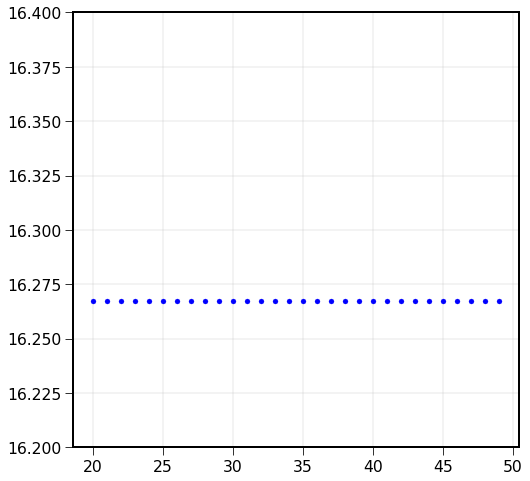

In [208]:
plt.plot(all_r,2.5*np.log10(all_aps),'bo')
#plt.ylim(0.,2.5*np.log10(all_aps.max()))
plt.grid()
plt.ylim(16.2,16.4)